In [1]:
import mne
import numpy as np
from scipy import io as sio, signal, stats
import matplotlib.pyplot as plt

mne.set_log_level('ERROR')

### Helper func.

In [2]:
def load_data(path='./ecog/ECoG_Handpose.mat'):
    data = sio.loadmat(path)
    sfreq = 1200.0

    time = data['y'][0]
    ecog = data['y'][1:61]
    stim = data['y'][61:]

    chan_idx = np.arange(1, ecog.shape[0] + 1)

    ch_names = ['ECoG{}'.format(i) for i in chan_idx] # list of channels names
    ch_names += ['gesture', 'thumb', 'index', 'middle', 'ring', 'little']
    ch_types = ['ecog']*len(ecog) # list of channels types (all EEG)
    ch_types += ['stim']
    ch_types += ['misc']*5

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types) # create mne info object
    raw = mne.io.RawArray(data['y'][1:], info) # create mne RawArray
    
    return raw

def preprocess(raw, bp=[1,300], notch=True, avg_ref=True):
    raw.filter(*bp)
    if notch:
        raw.notch_filter(np.arange(50,raw.info['sfreq']/2,50), notch_widths=2, trans_bandwidth=10)
    if avg_ref:
        raw.set_eeg_reference('average')
    return raw

### Basic I/O

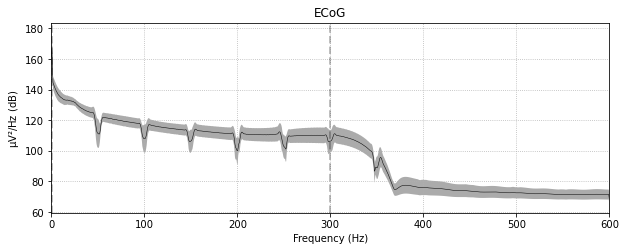

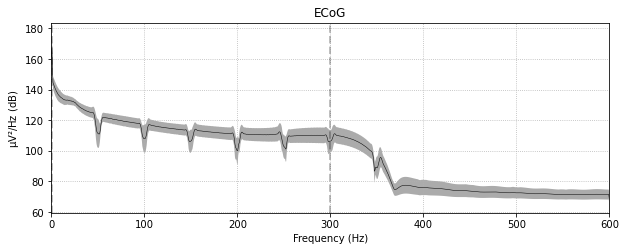

In [3]:
raw = load_data()
raw = preprocess(raw)

raw.plot_psd(average=True)

### Event-related potentials

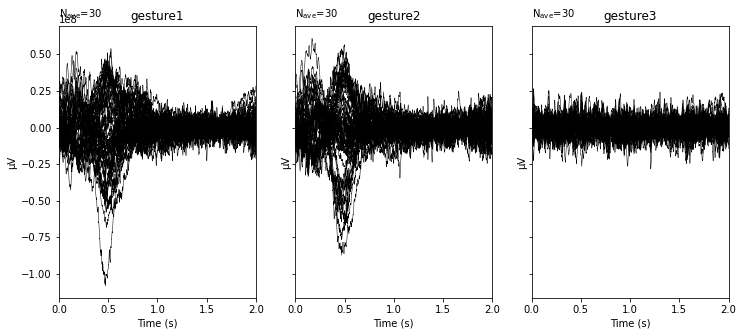

In [6]:
raw = load_data()
raw = preprocess(raw)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0.
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                picks=picks, baseline=None, preload=True,
                verbose=False)

f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))

for a, k in zip(ax, event_id.keys()):
    epochs[k].average().plot(axes=a,show=False)
    a.set_title(k)

### MNE stock decoders

#### CSP

Approx. 87% accuracy!

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from mne import io, pick_types, read_events, Epochs, EvokedArray
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

raw = load_data()
raw = preprocess(raw, bp=[50,250])
raw.resample(600)

events = mne.find_events(raw, stim_channel='gesture')
event_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}

tmin=0
tmax=2.

picks = mne.pick_types(raw.info, ecog=True)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True,
                    verbose=False)

# Get the labels
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

n_filter = 10

csp = CSP(n_components=n_filter, norm_trace=False)
clf_csp = make_pipeline(csp, StandardScaler(), LinearModel(LogisticRegression(solver='lbfgs', C=0.1, max_iter=10000)))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)

print('Accuracy: {:.3f} +/- {:.3f}'.format(scores.mean(), scores.std()))

Accuracy: 0.867 +/- 0.103


#### Vectorizer

Approx. 40% accuracy

In [17]:
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

print('Accuracy: {:.3f} +/- {:.3f}'.format(scores.mean(), scores.std()))

Accuracy: 0.389 +/- 0.061


#### XDAWN

No convergence...

In [31]:
clf = make_pipeline(Xdawn(n_components=3), 
                    Vectorizer(), 
                    MinMaxScaler(), 
                    LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'))

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(y))
for train, test in cv.split(epochs, y):
    clf.fit(epochs[train], y[train])
    preds[test] = clf.predict(epochs[test])

ValueError: Could not compute eigenvalues, ensure proper regularization (The leading minor of order 60 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.)

### Sprectal whitening

Pseudocode (MATLAB):

```
[arcoeff,v]=aryule(data(ch,:),10); % AR normalised values and its variance, model order p=10 
estimated=filter(-arcoeff(2:end),1,data(ch,:));
```

Python has equivalent functionality through statsmodels?

### Custom epoching - work in progress

Creating RawArray with float64 data, n_channels=66, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 5.00 Hz
- Upp

Text(0.5, 1.0, 'Finger data')

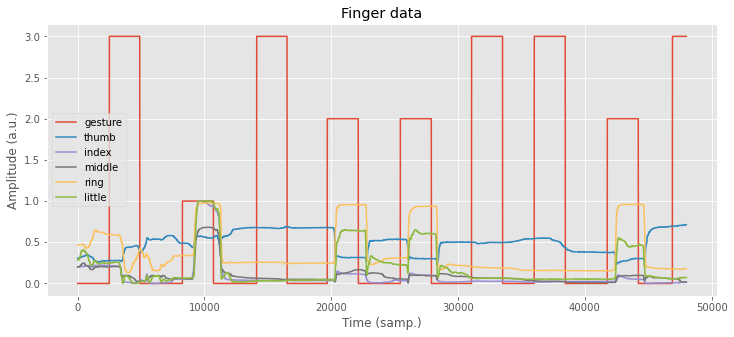

In [269]:
raw = load_data()
raw = preprocess(raw)

plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.plot(raw.get_data()[-6:, int(10*sfreq):int(50*sfreq)].T)
plt.legend(ch_names[-6:])
plt.xlabel('Time (samp.)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Finger data')

In [78]:
trigs = np.diff(raw['gesture'][0].squeeze())

In [86]:
trigs_rest = np.where(trigs < 0)[0]
trigs_gest1 = np.where(trigs == 1)[0]
trigs_gest2 = np.where(trigs == 2)[0]
trigs_gest3 = np.where(trigs == 3)[0]

(24000.0, 48000.0)

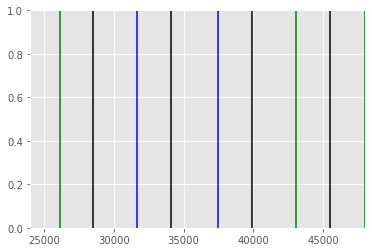

In [97]:
[plt.axvline(t, c='k') for t in trigs_rest]
[plt.axvline(t, c='r') for t in trigs_gest1]
[plt.axvline(t, c='b') for t in trigs_gest2]
[plt.axvline(t, c='g') for t in trigs_gest3]
plt.xlim(20*sfreq, 40*sfreq)

In [113]:
events = []

for i, t in enumerate([trigs_rest, trigs_gest1, trigs_gest2, trigs_gest3]):
    events.append(np.array([t, np.zeros(len(t)), i*np.ones(len(t))]).T)

events = np.vstack(events)

### Linear decoder - finger position (heavy...)

In [88]:
import spyeeg

In [4]:
raw = load_data()
raw.filter(1,300, picks=['ecog', 'misc'])
raw.set_eeg_reference('average')
raw.resample(600)
eeg = raw.get_data()[:-6].T
info = raw.info
fingers = raw.get_data()[-5:].T

Creating RawArray with float64 data, n_channels=66, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]


In [6]:
decoder = spyeeg.models.TRF.TRFEstimator(tmin=0, tmax=.5, srate = info['sfreq'], alpha=10.**np.arange(-10, 11, 1), mtype='backward')

In [7]:
scores = decoder.xval_eval(stats.zscore(eeg, axis=0), stats.zscore(fingers, axis=0), fit_mode='from_cov_10')

Training/Evaluating fold 1/5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mak616/anaconda2/envs/spyeeg/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-7aac23483546>", line 1, in <module>
    scores = decoder.xval_eval(stats.zscore(eeg, axis=0), stats.zscore(fingers, axis=0), fit_mode='from_cov_10')
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 494, in xval_eval
    scores[kfold, :] = self.score(X[test, :], y[test, :])
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 396, in score
    yhat = self.predict(Xtest)
  File "/home/mak616/Desktop/sPyEEG/spyeeg/models/TRF.py", line 371, in predict
    X = lag_matrix(X, lag_samples=self.lags, filling=0.)
  File "/home/mak616/Desktop/sPyEEG/spyeeg/utils.py", line 119, in lag_matrix
    dframe.fillna(filling, inplace=True)
  File "/home/mak616/anaconda2/envs/spyeeg/lib/python3.8/site-packages/pandas/core/frame.py", line 4459

TypeError: object of type 'NoneType' has no len()